## **Ejercicio 4: Finance Meets Data Science.**

Incluye:

1. **Visualización de Datos** - Gráficos de precios para Bitcoin, Ethereum y Cardano (últimos 30 días).
2. **Feature Engineering** - Categorización de riesgo, tendencias, varianza, características temporales y de volumen.
3. **Preparación de Datos para ML** - Reestructuración con lags y creación de features.
4. **Entrenamiento y Evaluación de Modelos** - OLS, RFR y XGB.

---

In [1]:
# Librerías estándar
import sys
from pathlib import Path

# Manipulación de datos
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Agregar raíz del proyecto al path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Importar módulos personalizados
from src.analytics.data_loader import (
    load_multiple_coins,
    prepare_time_series_dataframe
)
from src.analytics.feature_engineering import create_all_features
from src.analytics.preprocessing import (
    create_lagged_features,
    prepare_ml_dataset,
    encode_categorical_features
)
from src.analytics.models import train_all_models, get_best_model
from src.analytics.visualization import (
    plot_price_history,
    plot_price_comparison,
    plot_model_comparison,
    plot_predictions_vs_actual,
    plot_risk_distribution
)

# Configuración de visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Configuración completada")

✓ Configuración completada


### **1. Carga de Datos.**

In [2]:
# Cargar datos para 3 monedas (últimos 30 días)
coins = ['bitcoin', 'ethereum', 'cardano']
days = 30

df = load_multiple_coins(coins, days=days)

print(f"\nRegistros cargados: {len(df)}")
print(f"Rango de fechas: {df['date'].min()} a {df['date'].max()}")
print(f"\nDimensiones del DataFrame: {df.shape}")

pd.set_option('display.float_format', '{:.2f}'.format)
df.head(1)

INFO - Conexión a base de datos inicializada: crypto_data@localhost:5432
INFO - Cargando datos para 3 monedas: ['bitcoin', 'ethereum', 'cardano']


INFO - Cargados 93 registros totales para 3 monedas



Registros cargados: 93
Rango de fechas: 2025-10-01 00:00:00 a 2025-10-31 00:00:00

Dimensiones del DataFrame: (93, 5)


,coin_id,date,price_usd,volume_usd,market_cap_usd
0,bitcoin,2025-10-01,114024.23,57718901820.71,2272137555069.45


In [3]:
# Verificación de calidad de datos
print("Resumen de Calidad de Datos:")
print(f"\nValores faltantes:\n{df.isna().sum()}")
print(f"\nRegistros por moneda:\n{df['coin_id'].value_counts()}")
print(f"\nEstadísticas de precios:\n{df.groupby('coin_id')['price_usd'].describe()}")

Resumen de Calidad de Datos:

Valores faltantes:
coin_id           0
date              0
price_usd         0
volume_usd        0
market_cap_usd    0
dtype: int64

Registros por moneda:
coin_id
bitcoin     31
cardano     31
ethereum    31
Name: count, dtype: int64

Estadísticas de precios:
          count      mean     std       min       25%       50%       75%  \
coin_id                                                                     
bitcoin   31.00 114210.48 5676.42 106443.61 110047.59 113156.57 119557.48   
cardano   31.00      0.71    0.09      0.60      0.64      0.67      0.82   
ethereum  31.00   4115.99  273.29   3749.22   3889.85   3985.08   4356.30   

               max  
coin_id             
bitcoin  124773.51  
cardano       0.87  
ethereum   4689.13  


### **2. Visualización de Precios.**

INFO - Graficando historial de precios para 3 monedas
INFO - Gráfico guardado en c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\Python-Projects\temporal\md\outputs\plots\bitcoin_30d.png


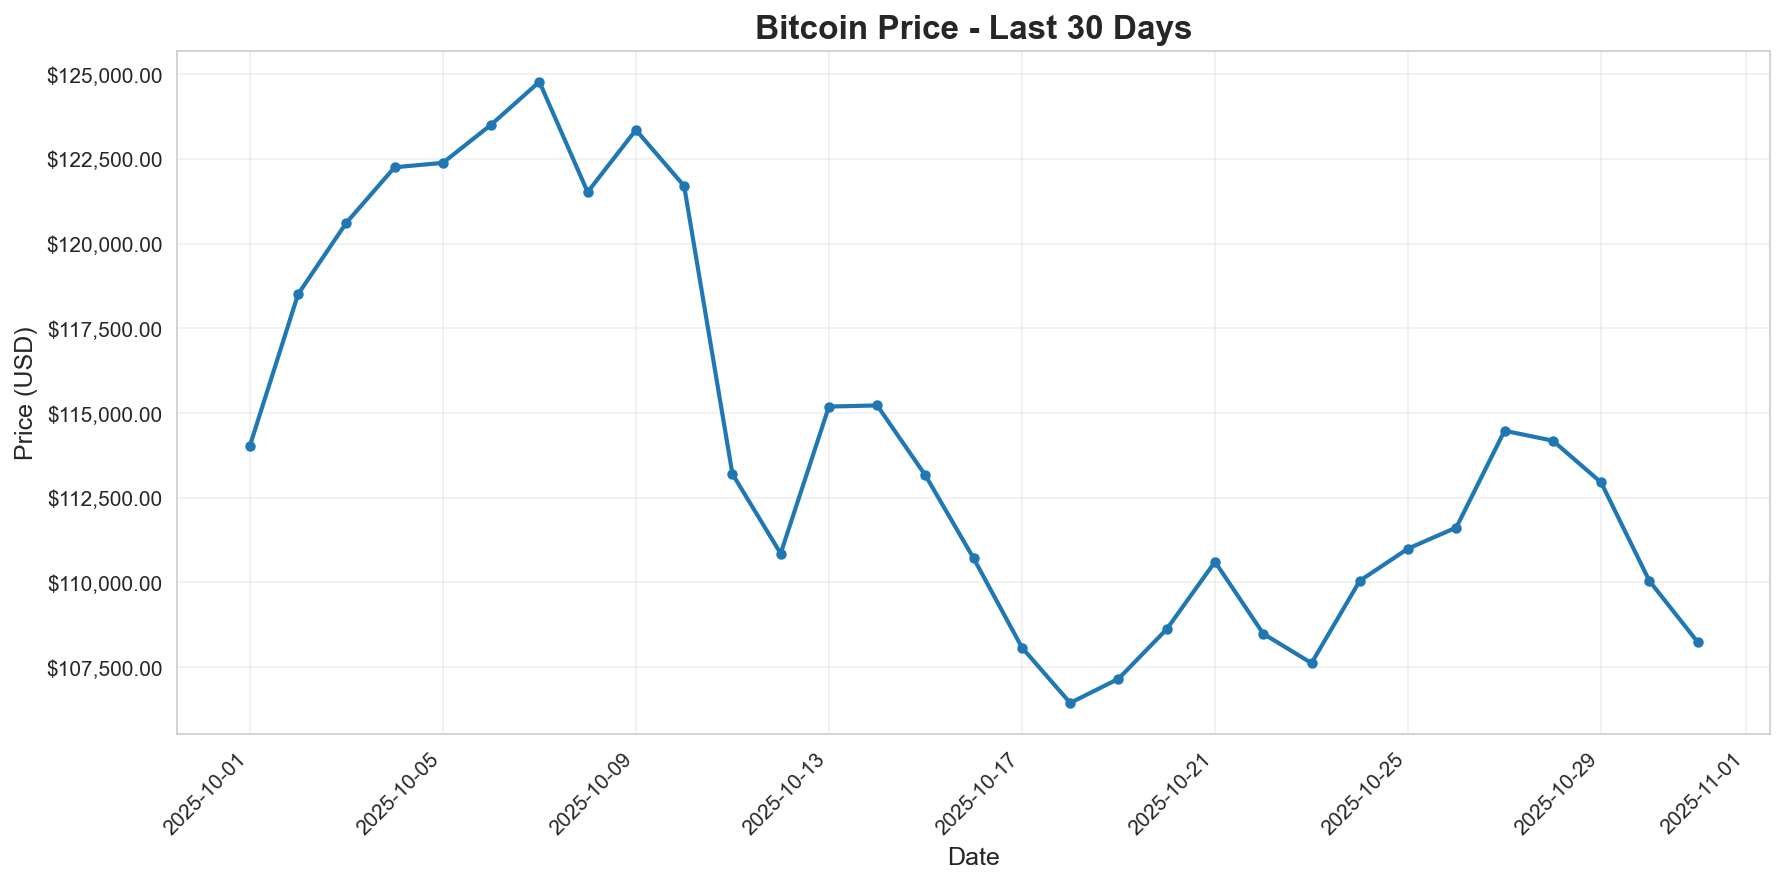

INFO - Gráfico guardado en c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\Python-Projects\temporal\md\outputs\plots\ethereum_30d.png


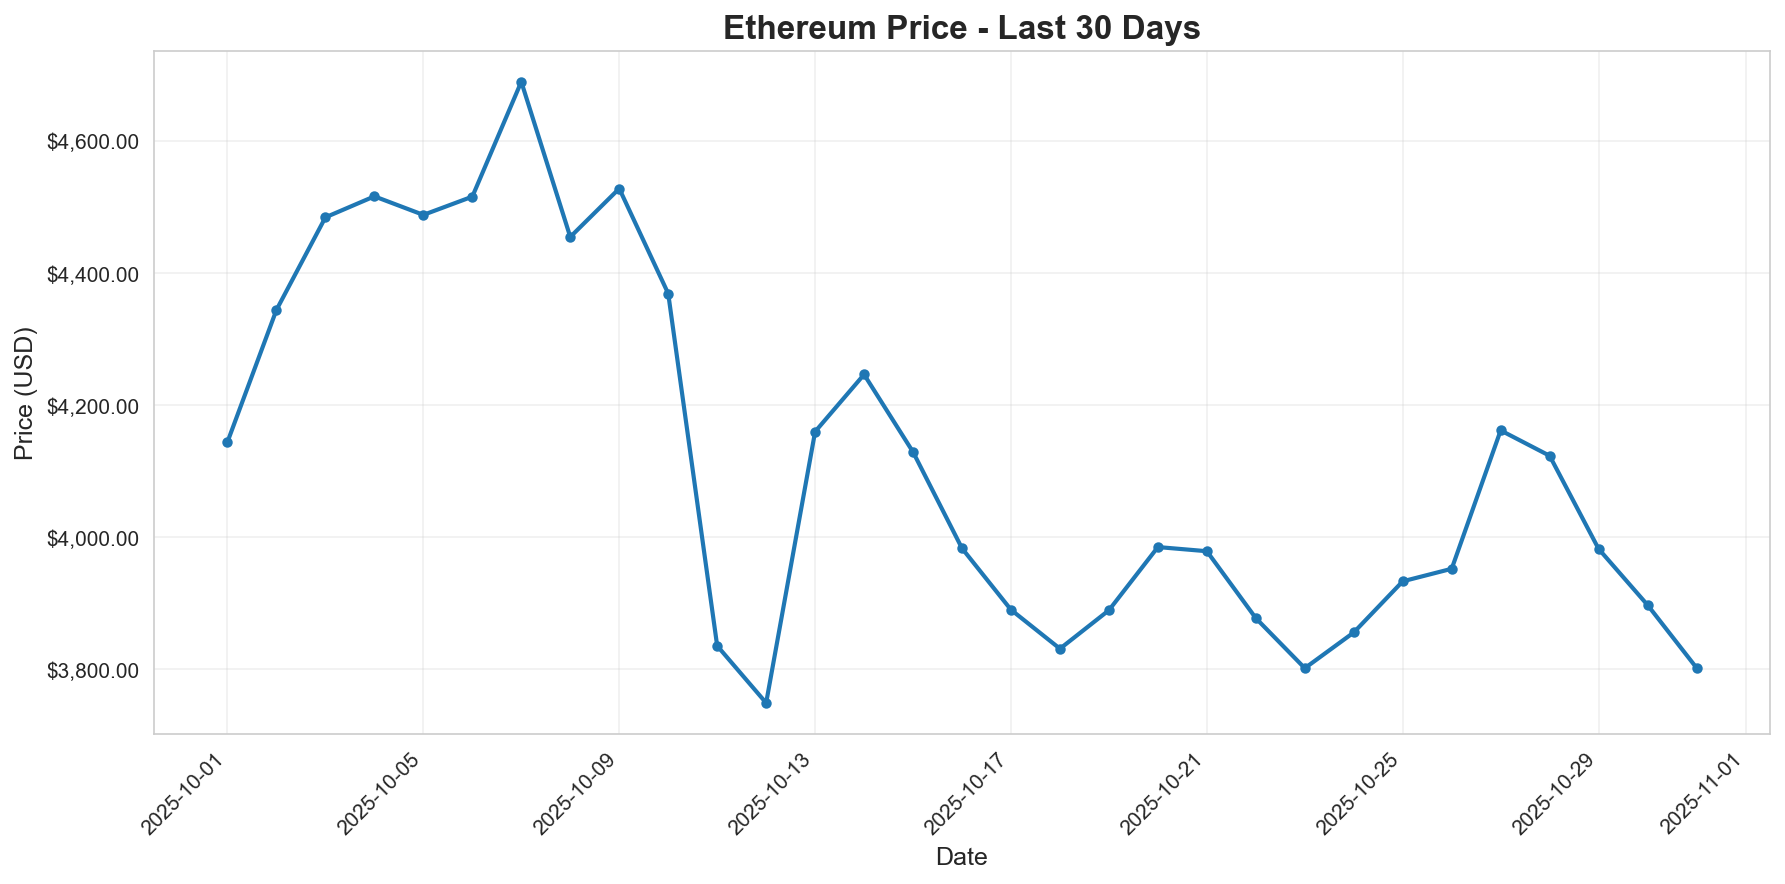

INFO - Gráfico guardado en c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\Python-Projects\temporal\md\outputs\plots\cardano_30d.png


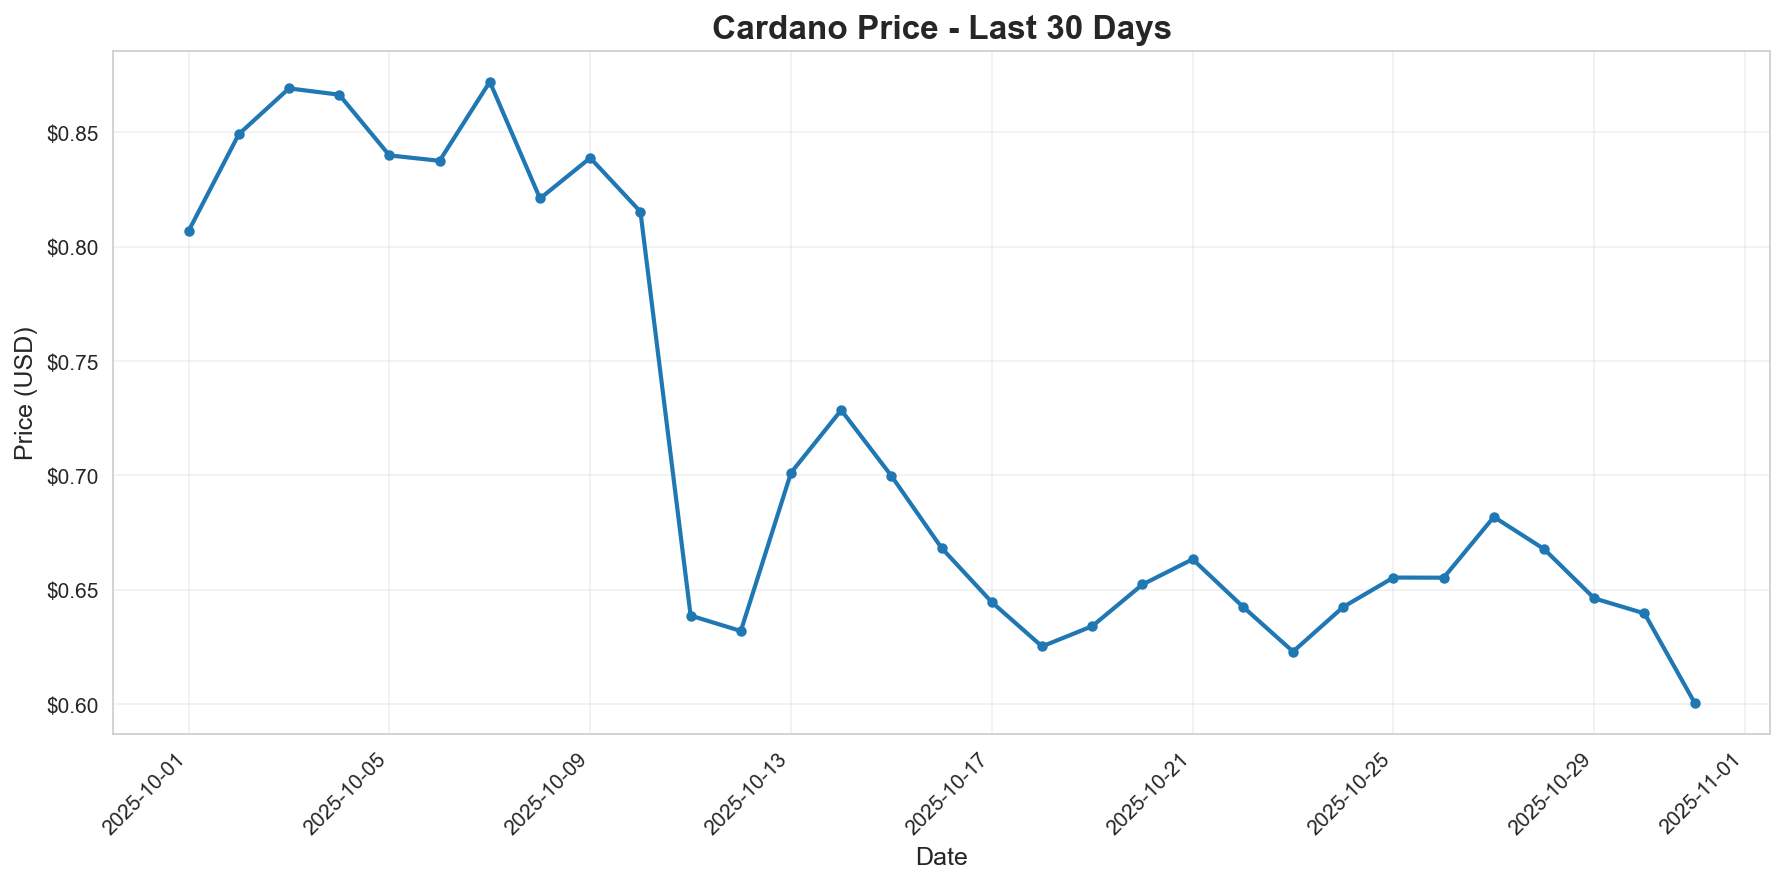


✓ Gráficos individuales guardados en c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\Python-Projects\temporal\md\outputs\plots/
  - bitcoin_30d.png
  - ethereum_30d.png
  - cardano_30d.png


In [4]:
# Generar gráficos individuales de precios para cada criptomoneda
output_dir = project_root / 'outputs' / 'plots'

plot_price_history(
    df,
    coins=coins,
    days=days,
    save_path=str(output_dir),
    show_plot=True
)

print(f"\n✓ Gráficos individuales guardados en {output_dir}/")
print(f"  - bitcoin_{days}d.png")
print(f"  - ethereum_{days}d.png")
print(f"  - cardano_{days}d.png")

INFO - Creando gráfico de comparación de precios para 3 monedas
INFO - Gráfico de comparación guardado en c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\Python-Projects\temporal\md\outputs\plots\price_comparison.png


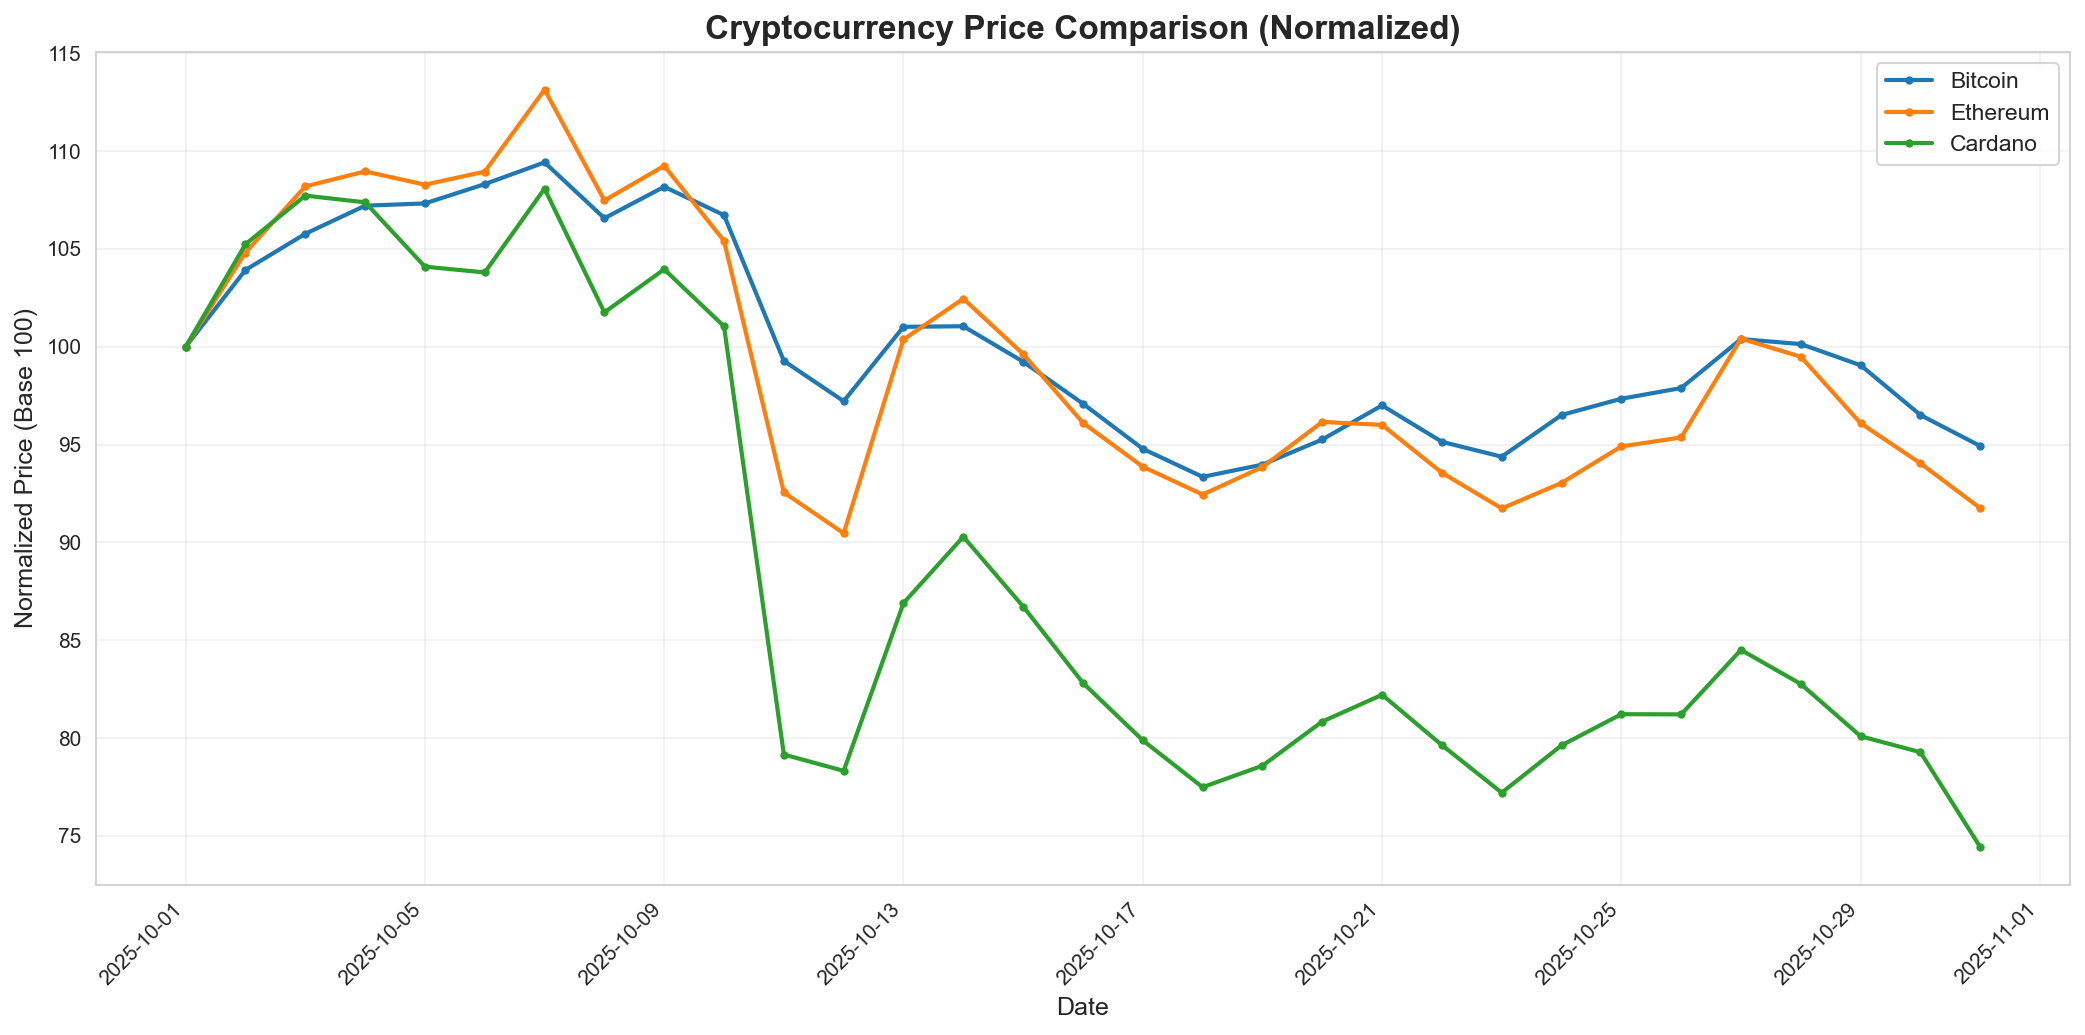


✓ Gráfico comparativo guardado en c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\Python-Projects\temporal\md\outputs\plots/price_comparison.png


In [5]:
# Gráfico comparativo (normalizado a base 100)
plot_price_comparison(
    df,
    coins=coins,
    normalize=True,
    save_path=str(output_dir / 'price_comparison.png'),
    show_plot=True
)

print(f"\n✓ Gráfico comparativo guardado en {output_dir}/price_comparison.png")

### **3. Feature Engineering.**

#### **3.1. Categorización de Riesgo.**

In [6]:
# Cargar todos los datos históricos para feature engineering
print("Cargando datos históricos completos para feature engineering...")

df_full = load_multiple_coins(coins, days=None)  # Cargar todos los datos disponibles
df_full = prepare_time_series_dataframe(df_full)

print(f"\nDataset completo: {len(df_full)} registros")
print(f"Rango de fechas: {df_full['date'].min()} a {df_full['date'].max()}")

df_full.head(1)

INFO - Conexión a base de datos inicializada: crypto_data@localhost:5432
INFO - Cargando datos para 3 monedas: ['bitcoin', 'ethereum', 'cardano']


Cargando datos históricos completos para feature engineering...


INFO - Cargados 276 registros totales para 3 monedas
INFO - Preparados 276 registros para análisis



Dataset completo: 276 registros
Rango de fechas: 2025-08-01 00:00:00 a 2025-10-31 00:00:00


,coin_id,date,price_usd,volume_usd,market_cap_usd
0,bitcoin,2025-08-01,115700.00,45238249453.36,2302199162425.12


In [7]:
# Crear todas las features
print("Creando todas las features (riesgo, tendencia, varianza, tiempo, volumen)...")

df_features = create_all_features(
    df_full,
    include_risk=True,
    include_trend=True,
    include_time=True,
    include_volume=True,
    include_holidays=True,
    include_statistics=False
)

print(f"\n✓ Features creadas. Nuevas dimensiones: {df_features.shape}")
print(f"\nColumnas de features:\n{df_features.columns.tolist()}")

df_features.head(1)

INFO - Creando todos los features para análisis de criptomonedas
INFO - Calculando categorías de riesgo (cumulative=True)
INFO - Distribución de riesgo:
risk_type
Low Risk       245
Medium Risk     31
Name: count, dtype: int64
INFO - Calculando tendencia de 7 días usando método regression


Creando todas las features (riesgo, tendencia, varianza, tiempo, volumen)...


INFO - Calculando varianza de precio de 7 días
INFO - Agregando features basados en tiempo
INFO - Agregando features basados en volumen
INFO - Agregando features de feriados (BONUS)
INFO - Feature engineering completado. Shape del DataFrame: (276, 19)
INFO - Features agregados: ['market_cap_usd', 'daily_return', 'risk_type', 'price_trend_7d', 'price_var_7d', 'day_of_week', 'is_weekend', 'week_of_year', 'month', 'quarter', 'volume_7d_avg', 'volume_ratio', 'volume_trend', 'is_us_holiday', 'is_china_holiday']



✓ Features creadas. Nuevas dimensiones: (276, 19)

Columnas de features:
['coin_id', 'date', 'price_usd', 'volume_usd', 'market_cap_usd', 'daily_return', 'risk_type', 'price_trend_7d', 'price_var_7d', 'day_of_week', 'is_weekend', 'week_of_year', 'month', 'quarter', 'volume_7d_avg', 'volume_ratio', 'volume_trend', 'is_us_holiday', 'is_china_holiday']


,coin_id,date,price_usd,volume_usd,market_cap_usd,daily_return,risk_type,price_trend_7d,price_var_7d,day_of_week,is_weekend,week_of_year,month,quarter,volume_7d_avg,volume_ratio,volume_trend,is_us_holiday,is_china_holiday
0,bitcoin,2025-08-01,115700.00,45238249453.36,2302199162425.12,NaN,Low Risk,NaN,NaN,4,0,31,8,3,NaN,NaN,NaN,0,0


INFO - Creando gráfico de distribución de riesgo


Distribución de Categorías de Riesgo:

risk_type  Low Risk  Medium Risk
coin_id                         
bitcoin          92            0
cardano          61           31
ethereum         92            0


INFO - Gráfico de distribución de riesgo guardado en c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\Python-Projects\temporal\md\outputs\plots\risk_distribution.png


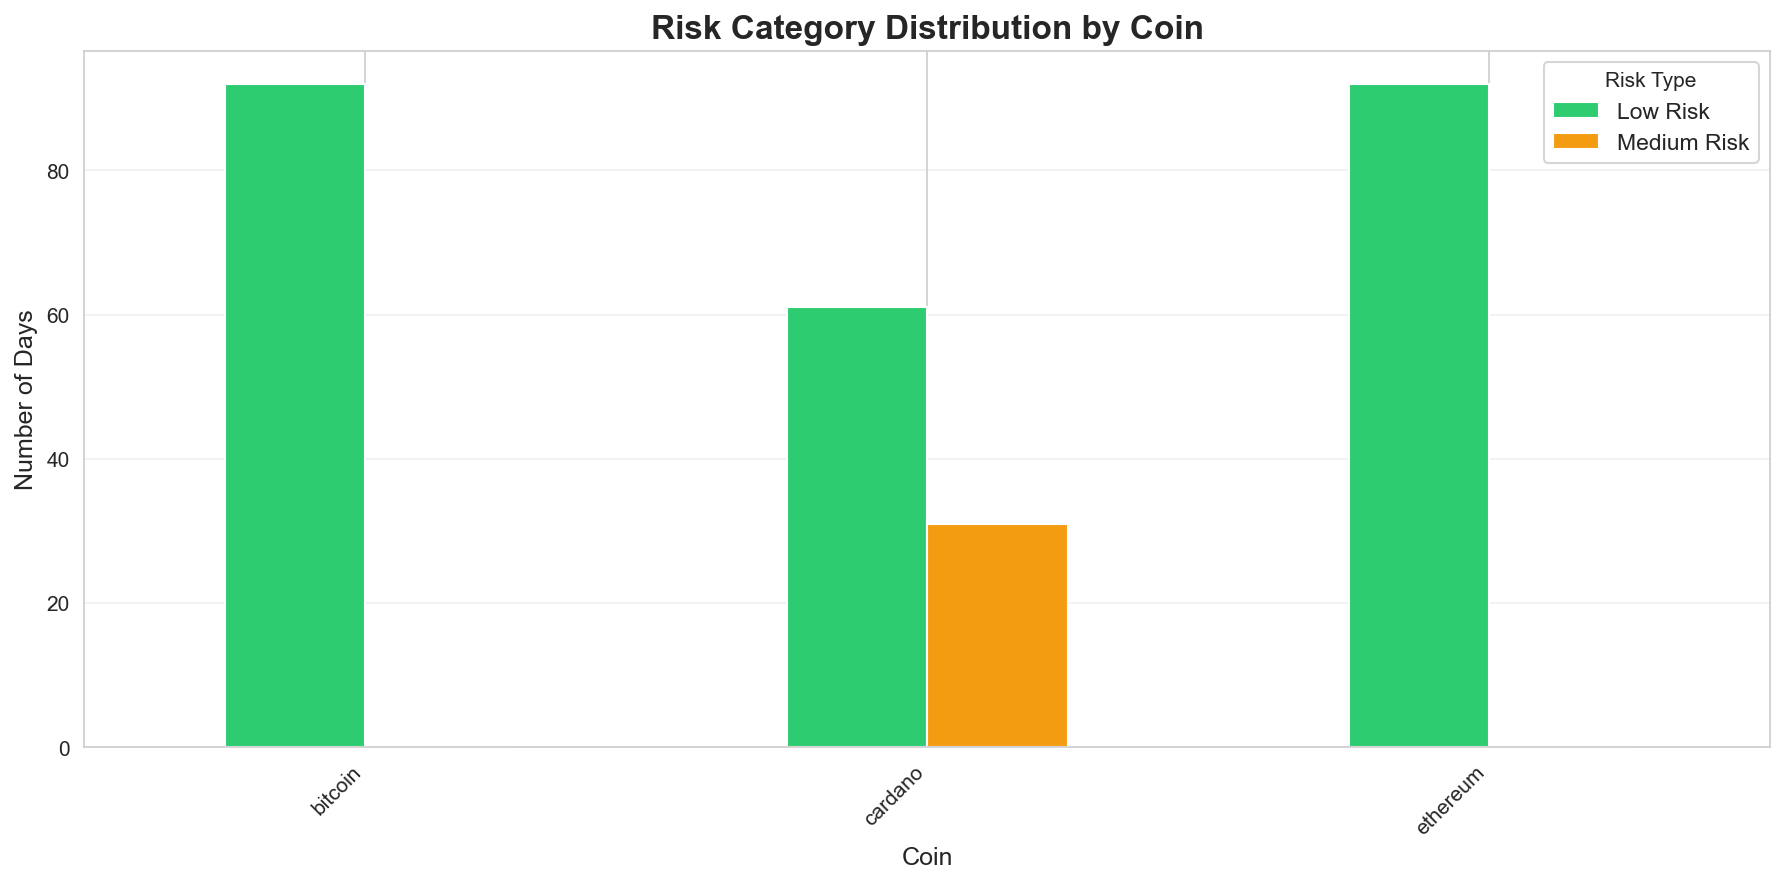

In [8]:
# Analizar distribución de riesgo
print("Distribución de Categorías de Riesgo:\n")
risk_dist = df_features.groupby(['coin_id', 'risk_type']).size().unstack(fill_value=0)
print(risk_dist)

# Visualizar distribución de riesgo
plot_risk_distribution(
    df_features,
    save_path=str(output_dir / 'risk_distribution.png'),
    show_plot=True
)

#### **3.2 Tendencia y Varianza**.

In [9]:
# Mostrar features de tendencia y varianza
trend_variance_cols = ['coin_id', 'date', 'price_usd', 'price_trend_7d', 'price_var_7d']

print("Muestra de features de Tendencia y Varianza a 7 días:\n")
print(df_features[trend_variance_cols].dropna().head(1))

# Estadísticas
print("\nEstadísticas de Tendencia (por moneda):")
print(df_features.groupby('coin_id')['price_trend_7d'].describe())

print("\nEstadísticas de Varianza (por moneda):")
print(df_features.groupby('coin_id')['price_var_7d'].describe())

Muestra de features de Tendencia y Varianza a 7 días:

   coin_id       date  price_usd  price_trend_7d  price_var_7d
7  bitcoin 2025-08-08  117463.47          320.73    2322333.26

Estadísticas de Tendencia (por moneda):
          count   mean    std      min     25%   50%    75%     max
coin_id                                                            
bitcoin   85.00 -21.43 844.92 -1838.38 -616.88 54.33 571.44 1940.57
cardano   85.00  -0.00   0.01    -0.03   -0.01 -0.00   0.01    0.03
ethereum  85.00   5.18  56.43  -112.57  -34.89 -5.12  46.15  138.94

Estadísticas de Varianza (por moneda):
          count       mean        std       min        25%        50%  \
coin_id                                                                 
bitcoin   85.00 6837228.95 6739308.93 363570.47 2732436.06 4648032.94   
cardano   85.00       0.00       0.00      0.00       0.00       0.00   
ethereum  85.00   35087.70   30976.81   2796.75   10869.40   27886.17   

                75%         max 

### **4. Reestructuración de Datos para ML.**

In [10]:
# Crear lagged features (price_lag_1 a price_lag_7)
print("Creando lagged features para ML...")

df_ml = create_lagged_features(df_features, target_col='price_usd', lags=7)

print(f"\nDimensiones del dataset ML: {df_ml.shape}")
print(f"\nLagged features creadas:")
print([col for col in df_ml.columns if 'lag' in col or 'target' in col])

# Mostrar muestra
ml_cols = ['coin_id', 'date', 'price_usd'] + [f'price_lag_{i}' for i in range(1, 8)] + ['price_target']
df_ml[ml_cols].dropna().head(1)

INFO - Creando 7 features de lag para price_usd
INFO - Features de lag creados: price_lag_1 hasta price_lag_7 y price_target


Creando lagged features para ML...

Dimensiones del dataset ML: (276, 27)

Lagged features creadas:
['price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4', 'price_lag_5', 'price_lag_6', 'price_lag_7', 'price_target']


,coin_id,date,price_usd,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5,price_lag_6,price_lag_7,price_target
7,bitcoin,2025-08-08,117463.47,115022.10,114128.35,115138.69,114199.11,112554.90,113234.61,115700.00,116688.37


In [11]:
# Codificar variables categóricas: risk_type y coin_id
categorical_cols = []

if 'risk_type' in df_ml.columns:
    categorical_cols.append('risk_type')
    
if 'coin_id' in df_ml.columns:
    categorical_cols.append('coin_id')

if categorical_cols:
    print(f"Codificando {len(categorical_cols)} features categóricas: {categorical_cols}")
    df_ml = encode_categorical_features(df_ml, categorical_cols, method='onehot')
    print(f"\n✓ Features categóricas codificadas")

# Mostrar todas las columnas de features
print(f"\nTotal de features disponibles: {len(df_ml.columns)}")
print(f"\nColumnas con coin_id codificado: {[col for col in df_ml.columns if 'coin_id_' in col]}")
print(f"\nTodas las columnas:\n{df_ml.columns.tolist()}")

INFO - Codificando 2 features categóricos usando onehot


Codificando 2 features categóricas: ['risk_type', 'coin_id']

✓ Features categóricas codificadas

Total de features disponibles: 28

Columnas con coin_id codificado: ['coin_id_cardano', 'coin_id_ethereum']

Todas las columnas:
['date', 'price_usd', 'volume_usd', 'market_cap_usd', 'daily_return', 'price_trend_7d', 'price_var_7d', 'day_of_week', 'is_weekend', 'week_of_year', 'month', 'quarter', 'volume_7d_avg', 'volume_ratio', 'volume_trend', 'is_us_holiday', 'is_china_holiday', 'price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4', 'price_lag_5', 'price_lag_6', 'price_lag_7', 'price_target', 'risk_type_Medium Risk', 'coin_id_cardano', 'coin_id_ethereum']


In [12]:
# Verificar valores faltantes
print("Resumen de valores faltantes:")
missing = df_ml.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing if len(missing) > 0 else "No hay valores faltantes")

Resumen de valores faltantes:
price_trend_7d    21
price_var_7d      21
price_lag_7       21
volume_7d_avg     18
volume_ratio      18
volume_trend      18
price_lag_6       18
price_lag_5       15
price_lag_4       12
price_lag_3        9
price_lag_2        6
daily_return       3
price_lag_1        3
price_target       3
dtype: int64


### **5. Entrenamiento de Modelos.**

**Requisito**: 
- Predecir el precio del día siguiente (T+1) basado en los 7 días anteriores y features
- Usar Linear Regression como baseline
- Mostrar mejora con otros modelos
- **Nota**: Omitir las primeras 7 filas (sin datos previos) y la última fila (sin objetivo)

#### **5.1 Preparación de Datos.**

In [13]:
# Preparar dataset ML con división train/test
print("Preparando dataset ML con división temporal train/test...")

# Seleccionar features para modelado
# Excluir: identificadores originales (ya codificados como one-hot), precio crudo y objetivo
# NOTA: coin_id fue codificado como one-hot (coin_id_bitcoin, coin_id_ethereum, coin_id_cardano)
#       y se incluyen automáticamente en las features
exclude_cols = ['coin_id', 'date', 'price_usd', 'price_target', 'daily_return']
feature_cols = [col for col in df_ml.columns if col not in exclude_cols]

print(f"\nSeleccionadas {len(feature_cols)} features para modelado")
print(f"Features de coin_id codificadas: {[c for c in feature_cols if 'coin_id_' in c]}")

# Preparar dataset
ml_data = prepare_ml_dataset(
    df_ml,
    target_col='price_target',
    feature_cols=feature_cols,
    scale_features=True,  # Aplicar StandardScaler
    scaling_method='standard',
    test_size=0.2  # División 80/20
)

# Extraer componentes
X_train = ml_data['X_train']
X_test = ml_data['X_test']
y_train = ml_data['y_train']
y_test = ml_data['y_test']
scaler = ml_data['scaler']

print("\n✓ Dataset preparado")
print(f"\nEntrenamiento: X={X_train.shape}, y={y_train.shape}")
print(f"Prueba: X={X_test.shape}, y={y_test.shape}")
print(f"\nMetadata:\n{ml_data['metadata']}")

Preparando dataset ML con división temporal train/test...

INFO - Preparando dataset ML
INFO - Eliminadas 24 filas con lags incompletos o target faltante
INFO - Filas restantes: 252
INFO - Seleccionados 24 features
INFO - Realizando división temporal train/test (test_size=0.2)
INFO - Período de entrenamiento: 2025-08-08 00:00:00 hasta 2025-10-13 00:00:00




Seleccionadas 24 features para modelado
Features de coin_id codificadas: ['coin_id_cardano', 'coin_id_ethereum']


INFO - Período de prueba: 2025-10-14 00:00:00 hasta 2025-10-30 00:00:00
INFO - Tamaño entrenamiento: 201, Tamaño prueba: 51
INFO - Aplicando escalado standard a 24 features
INFO - Escalado de features completado
INFO - Preparación de dataset ML completada
INFO - Entrenamiento: X=(201, 24), y=(201,)
INFO - Prueba: X=(51, 24), y=(51,)



✓ Dataset preparado

Entrenamiento: X=(201, 24), y=(201,)
Prueba: X=(51, 24), y=(51,)

Metadata:
{'n_features': 24, 'train_size': 201, 'test_size': 51, 'test_proportion': 0.2, 'scaling_applied': True, 'scaling_method': 'standard'}


#### **5.2 Entrenamiento y Evaluación de Modelos.**

In [14]:
# Entrenar todos los modelos
print("Entrenando todos los modelos...\n")
print("="*60)

results = train_all_models(
    X_train, y_train,
    X_test, y_test,
    include_xgboost=True
)

models = results['models']
results_df = results['results']
predictions = results['predictions']

print("\n" + "="*60)
print("✓ Todos los modelos entrenados y evaluados")

INFO - Entrenando todos los modelos
INFO - 
--- Entrenando Baseline: Regresión Lineal ---
INFO - Entrenando Regresión Lineal (Baseline)
INFO - Entrenamiento de Regresión Lineal completado
INFO - 
--- Entrenando Random Forest ---
INFO - Entrenando Random Forest (n_estimators=100, max_depth=10)


Entrenando todos los modelos...



INFO - Entrenamiento de Random Forest completado
INFO - 
--- Entrenando Gradient Boosting ---
INFO - Entrenando Gradient Boosting (n_estimators=100, lr=0.1)
INFO - Entrenamiento de Gradient Boosting completado
INFO - 
--- Entrenando XGBoost ---
INFO - Entrenando XGBoost (n_estimators=100, lr=0.1)
INFO - Entrenamiento de XGBoost completado
INFO - 
INFO - EVALUANDO TODOS LOS MODELOS
INFO - ============================================================
INFO - Comparando 4 modelos
INFO - Evaluando Linear Regression
INFO - Linear Regression - RMSE: 1333.46, MAE: 816.82, R²: 0.9993, MAPE: 24043.13%
INFO - Evaluando Random Forest
INFO - Random Forest - RMSE: 1814.39, MAE: 1000.56, R²: 0.9987, MAPE: 7.31%
INFO - Evaluando Gradient Boosting
INFO - Gradient Boosting - RMSE: 1878.64, MAE: 1086.02, R²: 0.9986, MAPE: 76.23%
INFO - Evaluando XGBoost
INFO - XGBoost - RMSE: 28805.27, MAE: 8834.27, R²: 0.6818, MAPE: 117.32%
INFO - 
Resultados de Comparación de Modelos:
INFO - 
            Model     RMSE 


✓ Todos los modelos entrenados y evaluados


#### **5.3 Comparación de Modelos.**

In [15]:
# Mostrar tabla de resultados
print("\nRESULTADOS DE COMPARACIÓN DE MODELOS:")
print("="*60)
print(results_df.to_string(index=False))

# Calcular mejora sobre baseline usando MAPE (más apropiado para múltiples escalas)
baseline_mape = results_df.loc[results_df['Model'] == 'Linear Regression', 'MAPE'].values[0]

results_df['MAPE_Mejora_%'] = ((baseline_mape - results_df['MAPE']) / baseline_mape * 100).round(2)

print("\n" + "="*60)
print("MEJORA SOBRE BASELINE (Linear Regression) - Métrica: MAPE")
print("="*60)
print(results_df[['Model', 'MAPE', 'MAPE_Mejora_%', 'RMSE', 'R2']].to_string(index=False))

print("\nMAPE (Mean Absolute Percentage Error) es apropiado")
print("para comparar modelos con múltiples monedas de diferentes escalas.")


RESULTADOS DE COMPARACIÓN DE MODELOS:
            Model     RMSE     MAE   R2     MAPE
Linear Regression  1333.46  816.82 1.00 24043.13
    Random Forest  1814.39 1000.56 1.00     7.31
Gradient Boosting  1878.64 1086.02 1.00    76.23
          XGBoost 28805.27 8834.27 0.68   117.32

MEJORA SOBRE BASELINE (Linear Regression) - Métrica: MAPE
            Model     MAPE  MAPE_Mejora_%     RMSE   R2
Linear Regression 24043.13           0.00  1333.46 1.00
    Random Forest     7.31          99.97  1814.39 1.00
Gradient Boosting    76.23          99.68  1878.64 1.00
          XGBoost   117.32          99.51 28805.27 0.68

MAPE (Mean Absolute Percentage Error) es apropiado
para comparar modelos con múltiples monedas de diferentes escalas.


INFO - Creando gráfico de comparación de modelos
INFO - Gráfico de comparación de modelos guardado en c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\Python-Projects\temporal\md\outputs\plots\model_comparison.png


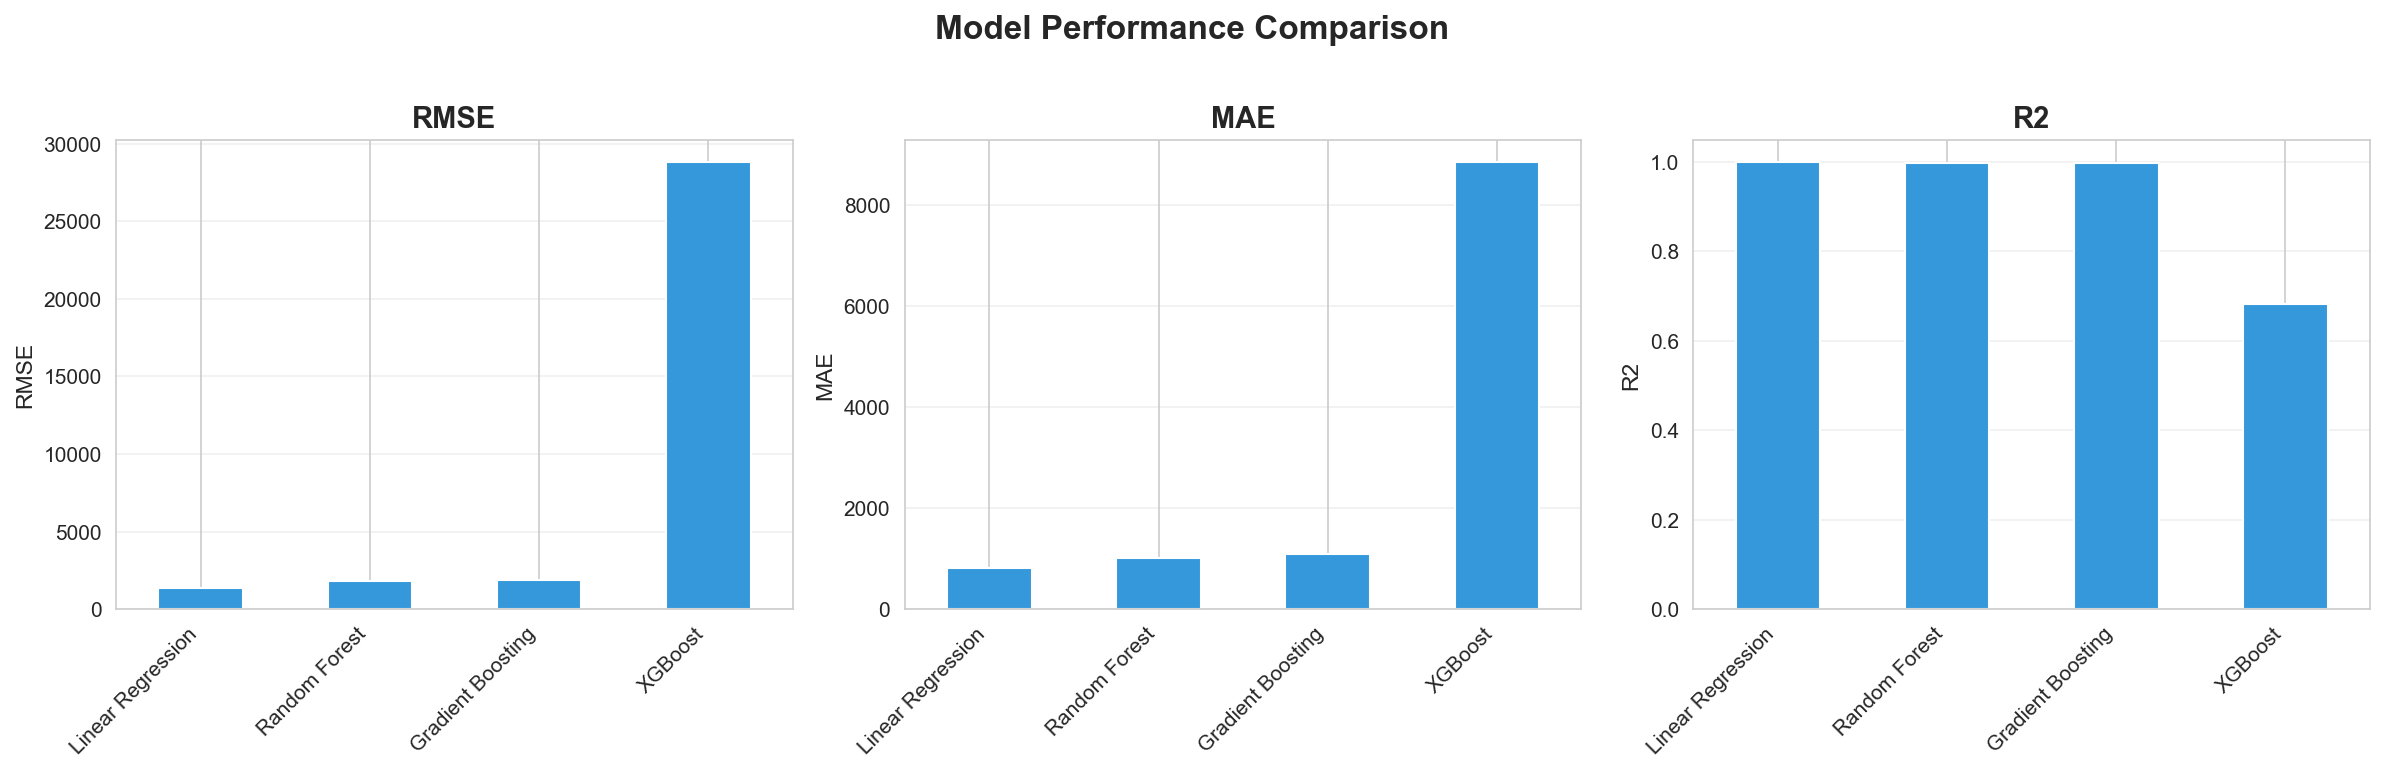

In [16]:
# Gráfico de comparación de modelos
plot_model_comparison(
    results_df[['Model', 'RMSE', 'MAE', 'R2']],
    save_path=str(output_dir / 'model_comparison.png'),
    show_plot=True
)

INFO - Creando gráfico de predicciones vs valores reales para 4 modelos
INFO - Gráfico de predicciones guardado en c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\Python-Projects\temporal\md\outputs\plots\predictions_vs_actual.png


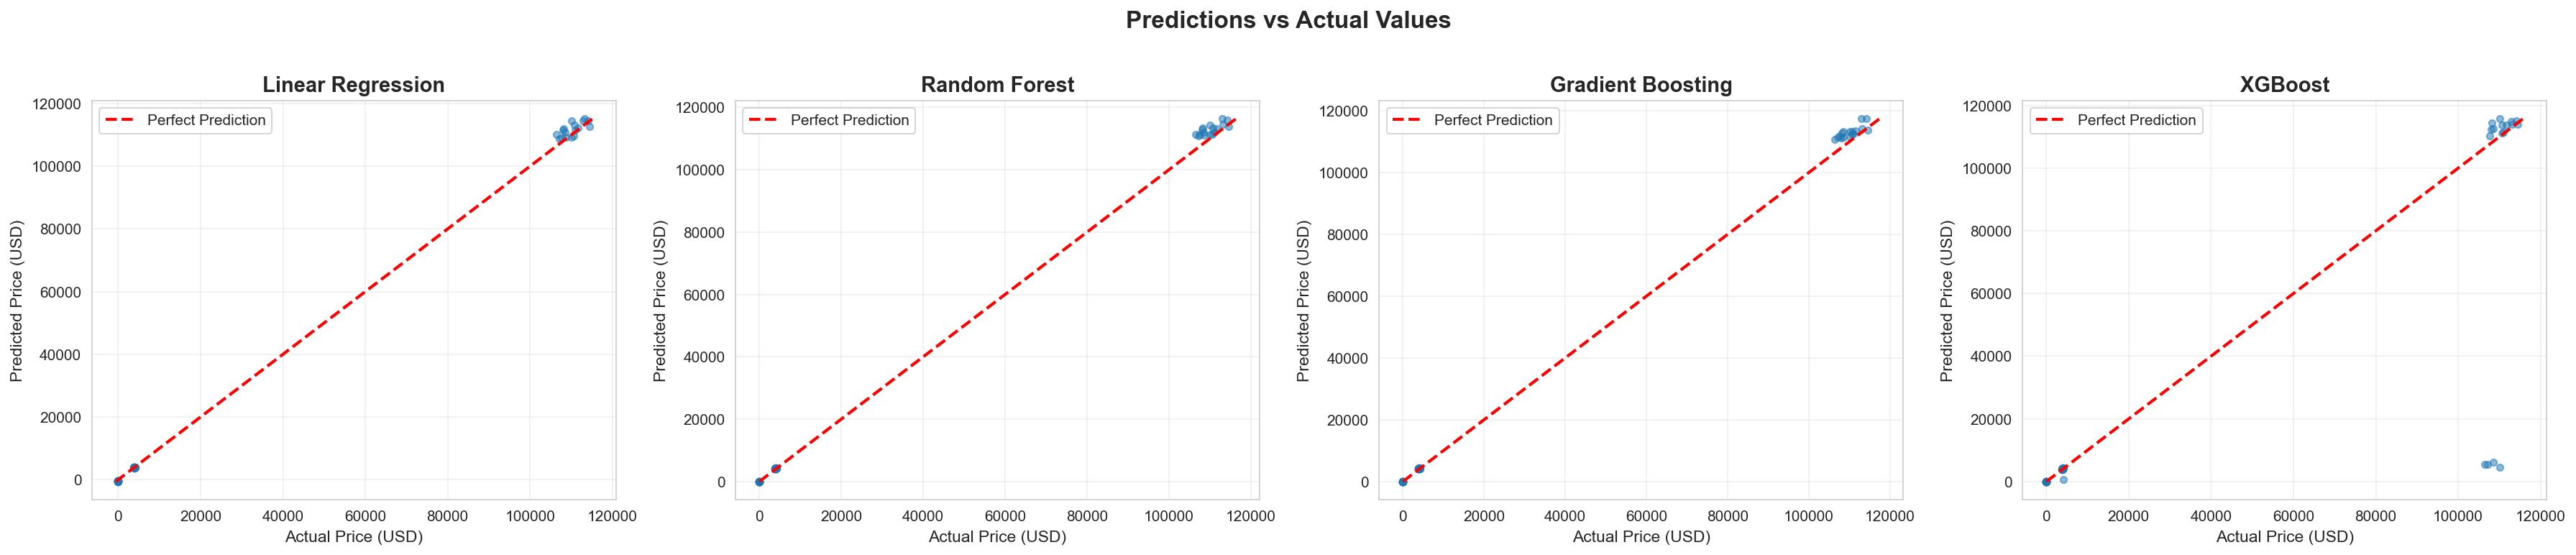

In [17]:
# Gráfico de predicciones vs valores reales
plot_predictions_vs_actual(
    y_test,
    predictions,
    save_path=str(output_dir / 'predictions_vs_actual.png'),
    show_plot=True
)

#### **5.4 Análisis de Importancia de Features.**

INFO - Comparando 4 modelos
INFO - Evaluando Linear Regression
INFO - Linear Regression - RMSE: 1333.46, MAE: 816.82, R²: 0.9993, MAPE: 24043.13%
INFO - Evaluando Random Forest
INFO - Random Forest - RMSE: 1814.39, MAE: 1000.56, R²: 0.9987, MAPE: 7.31%
INFO - Evaluando Gradient Boosting
INFO - Gradient Boosting - RMSE: 1878.64, MAE: 1086.02, R²: 0.9986, MAPE: 76.23%
INFO - Evaluando XGBoost
INFO - XGBoost - RMSE: 28805.27, MAE: 8834.27, R²: 0.6818, MAPE: 117.32%
INFO - 
Resultados de Comparación de Modelos:
INFO - 
            Model     RMSE     MAE   R2     MAPE
Linear Regression  1333.46  816.82 1.00 24043.13
    Random Forest  1814.39 1000.56 1.00     7.31
Gradient Boosting  1878.64 1086.02 1.00    76.23
          XGBoost 28805.27 8834.27 0.68   117.32
INFO - 
Mejor modelo: Random Forest (basado en MAPE)
INFO - Calculando importancia de features
INFO - 
Top 15 Features Más Importantes:
INFO - 
         feature  importance
     price_lag_6        0.17
     price_lag_4        0.15
   


Mejor Modelo: Random Forest


INFO - Creando gráfico de importancia de features
INFO - Gráfico de importancia de features guardado en c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\Python-Projects\temporal\md\outputs\plots\feature_importance.png


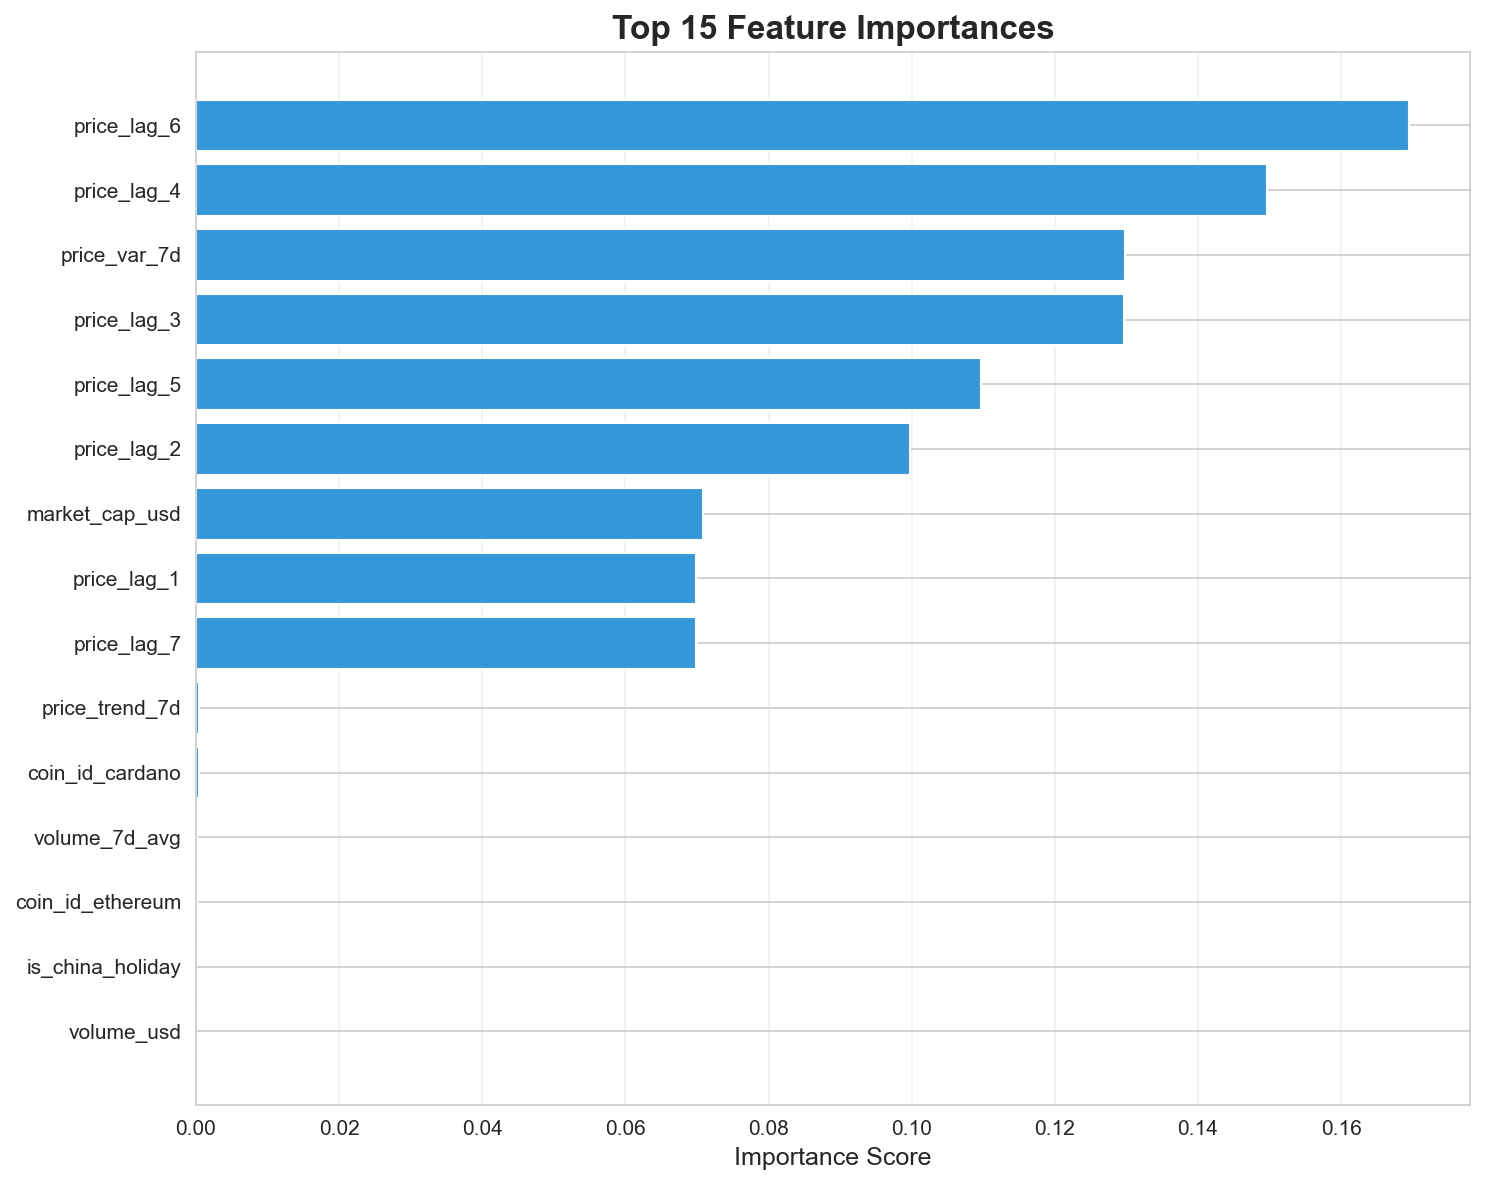

In [18]:
# Obtener mejor modelo usando MAPE (más apropiado para múltiples escalas de precios)
best_model_name, best_model = get_best_model(models, X_test, y_test, metric='MAPE')

print(f"\nMejor Modelo: {best_model_name}")

# Importancia de features (para modelos basados en árboles)
if hasattr(best_model, 'feature_importances_'):
    from src.analytics.models import calculate_feature_importance
    from src.analytics.visualization import plot_feature_importance
    
    importance_df = calculate_feature_importance(best_model, ml_data['feature_names'], top_n=15)
    
    # Gráfico de importancia de features
    plot_feature_importance(
        best_model,
        ml_data['feature_names'],
        top_n=15,
        save_path=str(output_dir / 'feature_importance.png'),
        show_plot=True
    )
else:
    print(f"{best_model_name} no tiene atributo feature_importances_")